In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchcrf import CRF 

def load_data(file_path):
    data = pd.read_csv(file_path, delimiter='\t', header=None, names=["Sentence #", "Word", "POS", "Tag"], encoding='ISO-8859-1')
    sentences = []
    ner_tags = []
    for _, grp in data.groupby('Sentence #'):
        sentences.append(grp['Word'].values.tolist())
        ner_tags.append(grp['Tag'].values.tolist())
    return sentences, ner_tags

file_path = "GMB_dataset.txt"
sentences, ner_tags = load_data(file_path)

# Train-test split
train_sentences, test_sentences, train_tags, test_tags = train_test_split(
    sentences, ner_tags, test_size=0.2, random_state=42)

In [2]:
# Vocabulary creation
word_vocab = {'<PAD>': 0, '<OOV>': 1}
tag_vocab = {'<PAD>': 0, '<UNK>': 1}

# Check and build word vocab
for sentence in sentences:
    for word in sentence:
        if word not in word_vocab:
            word_vocab[word] = len(word_vocab)

# Check tag vocab
for tags in ner_tags:
    for tag in tags:
        if tag not in tag_vocab:
            tag_vocab[tag] = len(tag_vocab)

# Reverse mapping for tags
idx2tag = {idx: tag for tag, idx in tag_vocab.items()}

# Dataset preparation
class NERDataset(Dataset):
    def __init__(self, sentences, tags, word_vocab, tag_vocab):
        self.sentences = sentences
        self.tags = tags
        self.word_vocab = word_vocab
        self.tag_vocab = tag_vocab
    
    def __len__(self):
        return len(self.sentences)

    # Convert sentence into into indexed sequence, and NER tags into indices using word/tag vocabulary
    def __getitem__(self, idx):
        sentence = [self.word_vocab.get(word, self.word_vocab['<OOV>']) for word in self.sentences[idx]]
        tag = [self.tag_vocab.get(tag, self.tag_vocab['<UNK>']) for tag in self.tags[idx]]
        return torch.tensor(sentence), torch.tensor(tag)

train_dataset = NERDataset(train_sentences, train_tags, word_vocab, tag_vocab)
test_dataset = NERDataset(test_sentences, test_tags, word_vocab, tag_vocab)

    
# Apply padding to sequences
def collate_fn(batch):
    sentences, tags = zip(*batch)
    sentences_padded = pad_sequence(sentences, batch_first=True, padding_value=0)
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=0)
    return sentences_padded, tags_padded

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

# BiLSTM-CRF Model
class BiLSTMCRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128, hidden_dim=256):
        super(BiLSTMCRF, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)
    
    def forward(self, x, tags=None):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        emissions = self.fc(lstm_out)
        if tags is not None:
            loss = -self.crf(emissions, tags, mask=(x != 0))
            return loss
        else:
            return self.crf.decode(emissions, mask=(x != 0))


In [3]:
# Sanity Checking before model run
# Check vocab sizes and sample words/tags
print("\nVocabulary sizes:")
print(f"Word vocab size: {len(word_vocab)}")
print(f"Tag vocab size: {len(tag_vocab)}")
print(f"Sample words: {list(word_vocab.keys())[:50]}")
print(f"Sample tags: {list(tag_vocab.keys())[:50]}")

# Check indexing for a few samples
for i in range(3):  # Print first 3 samples
    sentence_tensor, tag_tensor = train_dataset[i]
    sentence = [list(word_vocab.keys())[list(word_vocab.values()).index(idx)] for idx in sentence_tensor.tolist()]
    tags = [idx2tag[idx] for idx in tag_tensor.tolist()]
    print(f"Sample {i+1}:")
    print("Sentence:", sentence)
    print("Tags:", tags)


Vocabulary sizes:
Word vocab size: 8769
Tag vocab size: 20
Sample words: ['<PAD>', '<OOV>', 'Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'withdrawal', 'British', 'troops', 'from', 'that', 'country', '.', 'Iranian', 'officials', 'say', 'they', 'expect', 'get', 'access', 'sealed', 'sensitive', 'parts', 'plant', 'Wednesday', ',', 'after', 'an', 'IAEA', 'surveillance', 'system', 'begins', 'functioning', 'Helicopter', 'gunships', 'Saturday', 'pounded', 'militant', 'hideouts']
Sample tags: ['<PAD>', '<UNK>', 'O', 'B-geo', 'B-gpe', 'B-tim', 'B-org', 'I-geo', 'B-per', 'I-per', 'I-org', 'B-nat', 'I-tim', 'I-gpe', 'I-nat', 'B-art', 'I-art', 'B-eve', 'I-eve', 'Tag']
Sample 1:
Sentence: ['Mr.', 'Roed-Larsen', ',', 'who', 'visited', 'Damascus', 'last', 'week', ',', 'said', 'he', 'feels', 'Syria', 'has', 'stretched', 'out', ',', 'what', 'he', 'called', ',', 'a', 'genuine', 'hand', 'of', 'peace', 'and', 'Isr

In [4]:
# BiLSTM-CRF Model
class BiLSTMCRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128, hidden_dim=256):
        super(BiLSTMCRF, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)  # Initialize the CRF layer

    # Not including mask as per lecture slides since it is "None" anyway in our case
    def forward(self, x, tags=None):
        # Embedding layer
        x = self.embedding(x)
        
        # LSTM layer (bi-directional)
        lstm_out, _ = self.lstm(x)
        
        # Emission scores (output from the LSTM)
        emissions = self.fc(lstm_out)
        
        if tags is not None:
            # If tags are provided, calculate the CRF loss
            loss = -self.crf(emissions, tags)
            return loss
        else:
            # If no tags are provided, decode the predicted tags using CRF
            return self.crf.decode(emissions)

In [5]:
# Model instantiation and training, using Adam as optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMCRF(len(word_vocab), len(tag_vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [6]:
# Training
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for sentences, tags in train_loader:
        sentences, tags = sentences.to(device), tags.to(device)

        # Zero gradients before each update
        optimizer.zero_grad()
        
         # Forward pass: compute the loss
        loss = model(sentences, tags)
        
        # Backward pass: compute gradients
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader)}")


/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/torchcrf/__init__.py:249: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorCompare.cpp:530.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


Epoch 1/50, Loss: 628.2120686848958
Epoch 2/50, Loss: 262.09661173502604
Epoch 3/50, Loss: 152.0704453531901
Epoch 4/50, Loss: 95.50300557454428
Epoch 5/50, Loss: 59.82176717122396
Epoch 6/50, Loss: 37.47557067871094
Epoch 7/50, Loss: 22.518418782552082
Epoch 8/50, Loss: 13.342648518880209
Epoch 9/50, Loss: 8.243130696614584
Epoch 10/50, Loss: 5.043555094401042
Epoch 11/50, Loss: 3.175225830078125
Epoch 12/50, Loss: 2.095919189453125
Epoch 13/50, Loss: 1.5283687337239584
Epoch 14/50, Loss: 1.0893021647135417
Epoch 15/50, Loss: 0.8549027506510417
Epoch 16/50, Loss: 0.7098933919270833
Epoch 17/50, Loss: 0.5986568196614583
Epoch 18/50, Loss: 0.5101485188802083
Epoch 19/50, Loss: 0.4460982259114583
Epoch 20/50, Loss: 0.3956380208333333
Epoch 21/50, Loss: 0.3522749837239583
Epoch 22/50, Loss: 0.31644287109375
Epoch 23/50, Loss: 0.287479248046875
Epoch 24/50, Loss: 0.2585453287760417
Epoch 25/50, Loss: 0.23869303385416665
Epoch 26/50, Loss: 0.22033732096354167
Epoch 27/50, Loss: 0.2051904296

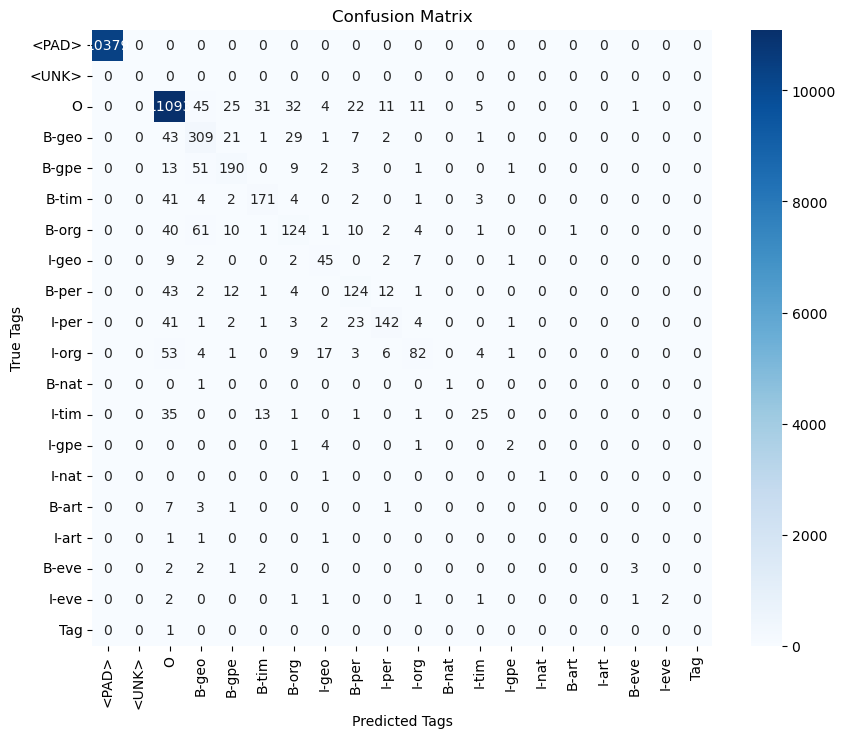

Classification Report:
              precision    recall  f1-score   support

       <PAD>       1.00      1.00      1.00     10379
       B-art       0.00      0.00      0.00        12
       B-eve       0.60      0.30      0.40        10
       B-geo       0.64      0.75      0.69       414
       B-gpe       0.72      0.70      0.71       270
       B-nat       1.00      0.50      0.67         2
       B-org       0.57      0.49      0.52       255
       B-per       0.64      0.62      0.63       199
       B-tim       0.77      0.75      0.76       228
       I-art       0.00      0.00      0.00         3
       I-eve       1.00      0.22      0.36         9
       I-geo       0.57      0.66      0.61        68
       I-gpe       0.33      0.25      0.29         8
       I-nat       1.00      0.50      0.67         2
       I-org       0.72      0.46      0.56       180
       I-per       0.80      0.65      0.71       220
       I-tim       0.62      0.33      0.43        76
    

/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [7]:
# Switch to model evaluation
model.eval()
all_predicted_tags = []
all_true_tags = []

with torch.no_grad():
    for sentences, tags in test_loader:
        sentences, tags = sentences.to(device), tags.to(device)
        predicted_tags = model(sentences)
        all_predicted_tags.extend(predicted_tags)
        all_true_tags.extend(tags.cpu().numpy())

# Flatten the lists for confusion matrix and classification report
all_predicted_tags = [tag for sentence in all_predicted_tags for tag in sentence]
all_true_tags = [tag for sentence in all_true_tags for tag in sentence]

# Convert predicted tag indices to tag names
all_predicted_tags = [idx2tag[tag] for tag in all_predicted_tags]
all_true_tags = [idx2tag[tag] for tag in all_true_tags]

# Generate confusion matrix
conf_matrix = confusion_matrix(all_true_tags, all_predicted_tags, labels=list(tag_vocab.keys()))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=tag_vocab.keys(), yticklabels=tag_vocab.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Tags')
plt.ylabel('True Tags')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(all_true_tags, all_predicted_tags))

# Compute test accuracy
accuracy = accuracy_score(all_true_tags, all_predicted_tags)
print(f"Test Accuracy: {accuracy}")

In [8]:
# Stricter test accuracy excluding "<PAD>"

# Exclude "O" and "Tag" from the labels
labels_to_include = [label for label in idx2tag.values() if label not in ["<PAD>"]]

# Generate classification report
detailed_report = classification_report(
    all_true_tags,
    all_predicted_tags,
    labels=labels_to_include,
    digits=4,
    zero_division=0  # To handle cases where precision/recall is undefined
)

print("Classification Report (Excluding '<PAD>'):")
print(detailed_report)


# Compute test accuracy
# Create a mask to exclude "O", "Tag", and "<PAD>" tags
mask = [(true_tag not in ["<PAD>"]) for true_tag in all_true_tags]

# Filter the predictions and true labels using the mask
filtered_true_tags = [true for true, m in zip(all_true_tags, mask) if m]
filtered_predicted_tags = [predicted for predicted, m in zip(all_predicted_tags, mask) if m]

# Calculate and print filtered accuracy
filtered_accuracy = accuracy_score(filtered_true_tags, filtered_predicted_tags)
print(f"Filtered Test Accuracy (Excluding <PAD>) : {filtered_accuracy:.4f}")


Classification Report (Excluding '<PAD>'):
              precision    recall  f1-score   support

       <UNK>     0.0000    0.0000    0.0000         0
           O     0.9710    0.9834    0.9772     11280
       B-geo     0.6358    0.7464    0.6867       414
       B-gpe     0.7170    0.7037    0.7103       270
       B-tim     0.7738    0.7500    0.7617       228
       B-org     0.5662    0.4863    0.5232       255
       I-geo     0.5696    0.6618    0.6122        68
       B-per     0.6359    0.6231    0.6294       199
       I-per     0.7978    0.6455    0.7136       220
       I-org     0.7193    0.4556    0.5578       180
       B-nat     1.0000    0.5000    0.6667         2
       I-tim     0.6250    0.3289    0.4310        76
       I-gpe     0.3333    0.2500    0.2857         8
       I-nat     1.0000    0.5000    0.6667         2
       B-art     0.0000    0.0000    0.0000        12
       I-art     0.0000    0.0000    0.0000         3
       B-eve     0.6000    0.3000    0

In [9]:
# Problem 2

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, recall_score


# Load the data
data = pd.read_csv('Spam_SMS.csv')

# Rename columns for consistency
data.columns = ['Class', 'Message']

# Encode labels
data['Class'] = data['Class'].map({'ham': 0, 'spam': 1})

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Message'], data['Class'], test_size=0.2, random_state=42
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=512)

# Convert to dataset format
class SMSDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SMSDataset(train_encodings, list(train_labels))
test_dataset = SMSDataset(test_encodings, list(test_labels))


In [11]:

# Load pre-trained BERT model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',          
    eval_strategy="epoch",           # evaluate after each epoch
    save_strategy="epoch",           # save model after each epoch
    learning_rate=2e-5,              # learning rate
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    num_train_epochs=5,              # number of training epochs
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            
    save_total_limit=1,              # only save the best model
    load_best_model_at_end=True,     # load the best model
)


# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    sensitivity = recall_score(labels, preds, pos_label=1)
    specificity = recall_score(labels, preds, pos_label=0)
    return {
        'accuracy': acc,
        'sensitivity': sensitivity,
        'specificity': specificity
    }

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Train and evaluate the model
trainer.train()
results = trainer.evaluate()

# Display metrics
print(f"Test Accuracy: {results['eval_accuracy']:.4f}")
print(f"Test Sensitivity: {results['eval_sensitivity']:.4f}")
print(f"Test Specificity: {results['eval_specificity']:.4f}")


Epoch,Training Loss,Validation Loss,Accuracy,Sensitivity,Specificity
1,No log,0.028358,0.993722,0.981366,0.995807
2,0.052500,0.036833,0.990135,0.937888,0.998952
3,0.052500,0.027946,0.995516,0.987578,0.996855
4,0.006700,0.026807,0.995516,0.987578,0.996855
5,0.006700,0.028067,0.995516,0.987578,0.996855


Test Accuracy: 0.9955
Test Sensitivity: 0.9876
Test Specificity: 0.9969
